In [1]:
#导包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = "SimHei" #解决中文乱码问题
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor

In [2]:
#读取数据

df_train = pd.read_csv(r'../DataMining/data_format1\train_format1.csv')
df_test = pd.read_csv(r'../DataMining/data_format1\test_format1.csv')
user_info = pd.read_csv(r'../DataMining/data_format1\user_info_format1.csv')
user_log = pd.read_csv(r'../DataMining/data_format1\user_log_format1.csv')

print(df_test.shape,df_train.shape)
print(user_info.shape,user_log.shape)

(261477, 3) (260864, 3)
(424170, 3) (54925330, 7)


In [3]:
#使用空值去替换
user_info['age_range'].replace(0.0,np.nan,inplace=True)
user_info['gender'].replace(2.0,np.nan,inplace=True)

user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int64  
 1   age_range  329039 non-null  float64
 2   gender     407308 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 9.7 MB


In [4]:
user_info['age_range'].replace(np.nan,-1,inplace=True)
user_info['gender'].replace(np.nan,-1,inplace=True)
# user_info['age_range'].replace(np.nan,1,inplace=True)
# user_info['gender'].replace(np.nan,0,inplace=True)

Text(0.5, 1.0, '用户年龄分布')

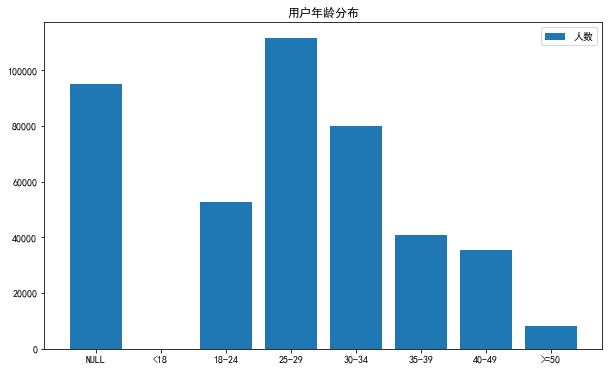

In [5]:
#年龄分布可视化
fig = plt.figure(figsize = (10, 6))
x = np.array(["NULL","<18","18-24","25-29","30-34","35-39","40-49",">=50"])
#<18岁为1；[18,24]为2； [25,29]为3； [30,34]为4；[35,39]为5；[40,49]为6； > = 50时为7和8
y = np.array([user_info[user_info['age_range'] == -1]['age_range'].count(),
             user_info[user_info['age_range'] == 1]['age_range'].count(),
             user_info[user_info['age_range'] == 2]['age_range'].count(),
             user_info[user_info['age_range'] == 3]['age_range'].count(),
             user_info[user_info['age_range'] == 4]['age_range'].count(),
             user_info[user_info['age_range'] == 5]['age_range'].count(),
             user_info[user_info['age_range'] == 6]['age_range'].count(),
             user_info[user_info['age_range'] == 7]['age_range'].count() + 
              user_info[user_info['age_range'] == 8]['age_range'].count()])
plt.bar(x,y,label='人数')
plt.legend()
plt.title('用户年龄分布')

Text(0.5, 1.0, '用户性别分布')

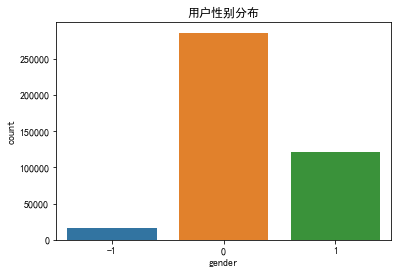

In [6]:
sns.countplot(x='gender',order=[-1,0,1],data=user_info)
plt.title('用户性别分布')

'\n1.年龄空值的比较多，性别空值的少\n2.年龄主要在18-39之间\n3.大多数是女性\n'

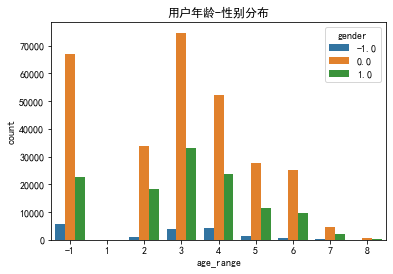

In [7]:
sns.countplot(x='age_range',order=[-1,1,2,3,4,5,6,7,8],hue='gender',data=user_info)
plt.title('用户年龄-性别分布')
'''
1.年龄空值的比较多，性别空值的少
2.年龄主要在18-39之间
3.大多数是女性
'''

In [8]:
#特征值合并

df_train = pd.merge(df_train,user_info,on="user_id",how="left")
 
total_logs_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"]])["item_id"].count().reset_index()
 
total_logs_temp.rename(columns={"seller_id":"merchant_id","item_id":"total_item_id"},inplace=True)
 
df_train = pd.merge(df_train,total_logs_temp,on=["user_id","merchant_id"],how="left")
 
unique_item_id = user_log.groupby(["user_id","seller_id","item_id"]).count().reset_index()[["user_id","seller_id","item_id"]]
 
unique_item_id_cnt = unique_item_id.groupby(["user_id","seller_id"]).count().reset_index()
 
unique_item_id_cnt.rename(columns={"seller_id":"merchant_id","item_id":"unique_item_id"},inplace=True)
 
df_train = pd.merge(df_train, unique_item_id_cnt, on=["user_id", "merchant_id"], how="left")
 
cat_id_temp = user_log.groupby(["user_id", "seller_id", "cat_id"]).count().reset_index()[["user_id", "seller_id", "cat_id"]]
 
cat_id_temp_cnt = cat_id_temp.groupby(["user_id", "seller_id"]).count().reset_index()
 
cat_id_temp_cnt.rename(columns={"seller_id":"merchant_id","cat_id":"total_cat_id"},inplace=True)
 
df_train = pd.merge(df_train, cat_id_temp_cnt, on=["user_id", "merchant_id"], how="left")
 
time_temp = user_log.groupby(["user_id", "seller_id", "time_stamp"]).count().reset_index()[["user_id", "seller_id", "time_stamp"]]
 
time_temp_cnt = time_temp.groupby(["user_id", "seller_id"]).count().reset_index()
 
time_temp_cnt.rename(columns={"seller_id":"merchant_id","time_stamp":"total_time_temp"},inplace=True)
 
df_train = pd.merge(df_train, time_temp_cnt, on=["user_id", "merchant_id"], how="left")
 
click_temp = user_log.groupby(["user_id", "seller_id", "action_type"])["item_id"].count().reset_index()
 
click_temp.rename(columns={"seller_id":"merchant_id","item_id":"times"},inplace=True)
 
click_temp["clicks"] = click_temp["action_type"] == 0
 
click_temp["clicks"] = click_temp["clicks"] * click_temp["times"]
 
click_temp["shopping_cart"] = click_temp["action_type"] == 1
click_temp["shopping_cart"] = click_temp["shopping_cart"] * click_temp["times"]
 
click_temp["purchases"] = click_temp["action_type"] == 2
click_temp["purchases"] = click_temp["purchases"] * click_temp["times"]
 
click_temp["favourites"] = click_temp["action_type"] == 3
click_temp["favourites"] = click_temp["favourites"] * click_temp["times"]
 
four_features = click_temp.groupby(["user_id", "merchant_id"]).sum().reset_index()
 
#删除相关列
four_features = four_features.drop(["action_type", "times"], axis=1)
 
#合并
df_train = pd.merge(df_train, four_features, on=["user_id", "merchant_id"], how="left")
 
#缺失值向前填充
df_train = df_train.fillna(method="ffill")
 

In [9]:
# user_info['age_range'].replace(np.nan,1,inplace=True)
# user_info['gender'].replace(np.nan,0,inplace=True)
# df_train['age_range'].replace(-1,np.nan,inplace=True)
# df_train['gender'].replace(-1,np.nan,inplace=True)

In [10]:
# print(df_train.shape)
# df_train_dropnan=df_train.dropna(axis=0,how='any')
# df_train_dropnan.shape
df_train

,user_id,merchant_id,label,age_range,gender,total_item_id,unique_item_id,total_cat_id,total_time_temp,clicks,shopping_cart,purchases,favourites
0,34176,3906,0,6.0,0.0,39,20,6,9,36,0,1,2
1,34176,121,0,6.0,0.0,14,1,1,3,13,0,1,0
2,34176,4356,1,6.0,0.0,18,2,1,2,12,0,6,0
3,34176,2217,0,6.0,0.0,2,1,1,1,1,0,1,0
4,230784,4818,0,-1.0,0.0,8,1,1,3,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260859,359807,4325,0,4.0,1.0,20,6,2,1,18,0,2,0
260860,294527,3971,0,-1.0,1.0,17,3,1,2,13,0,1,3
260861,294527,152,0,-1.0,1.0,9,1,1,1,7,0,1,1
260862,294527,2537,0,-1.0,1.0,1,1,1,1,0,0,1,0


In [11]:
#将构建好的特征保存
df_train.to_csv("df_train.csv",index=None)